# Data Preprocessing
This notebook is used to explore different methods for preprocessing and discuss which ones make sense for our use case.

## Imports

In [43]:
import os
import numpy as np
import pandas as pd
import pickle
import datetime
import scipy.fftpack

from dataloader import dataloader

# Matplot Setup
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (30,20)
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']= 1


# DataLoader Setup and Loading

In [34]:
data_path = 'Dataset/Converted_120Hz/'

# Features
f_params = ['position_0', 'position_1']
t_params = ['position_0', 'position_1']

# Window length
win_len = 120 
target_len = 30
stride = 2


In [8]:
data = dataloader(data_path, win_len = win_len, target_len = target_len, stride = stride, feature_params= f_params, target_params= t_params, test_split=0.1, val_split=0.1, downsample_rate=None, seed=11, stack=True)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
sample_rate = data['sample_rate']

2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle
2021-11-26-20-05-14_wobble_interpolated_120Hz.pickle
2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle
2022-01-13-17-18-38_wobble_interpolated_120Hz.pickle
2022-01-13-17-34-38_wobble_interpolated_120Hz.pickle
2022-01-13-17-48-10_wobble_interpolated_120Hz.pickle
2022-01-13-18-02-22_wobble_interpolated_120Hz.pickle
2022-01-20-15-23-37_wobble_interpolated_120Hz.pickle
2022-01-20-15-38-51_wobble_interpolated_120Hz.pickle
Train Idxs: [21, 26, 101, 49, 117, 28, 51, 122, 107, 121, 54, 60, 20, 99, 66, 52, 105, 11, 41, 31, 102, 115, 106, 69, 78, 100, 95, 46, 47, 87, 111, 18, 93, 96, 72, 38, 123, 19, 108, 68, 8, 3, 103, 59, 50, 114, 53, 5, 85, 40, 110, 98, 118, 7, 14, 44, 89, 57, 10, 94, 27, 23, 79, 64, 43, 70, 67, 17, 112, 120, 119, 84, 37, 74, 1, 12, 34, 4, 45, 32, 48, 92, 109, 24, 82, 71, 33, 76, 13, 55, 81, 91, 80, 63, 25]. 	Total train length: 285050. 
Test Idxs: [73, 2, 77, 9, 16, 116, 0, 36, 61, 56, 29, 97, 39, 104, 6]. 				Total tes

# Frequency Analysis

We calculate the _Fourier Transform_ of our signals to investigate the spectral energy of our data.
The energy per band and cumulative energy per band are calculated and shown. We get the following results: <br>

Most occuring frequencies in our dataset are __very low__. \
Frequencies up to __5 Hz__ already carry __98.40%__ of the average signal energy. \
Frequencies up to __10 Hz__  carry __99.24%__ of the average signal energy.
\
\
_Conclusion_: \
Use __LowPass Filter__ and downsample to __10 Hz__

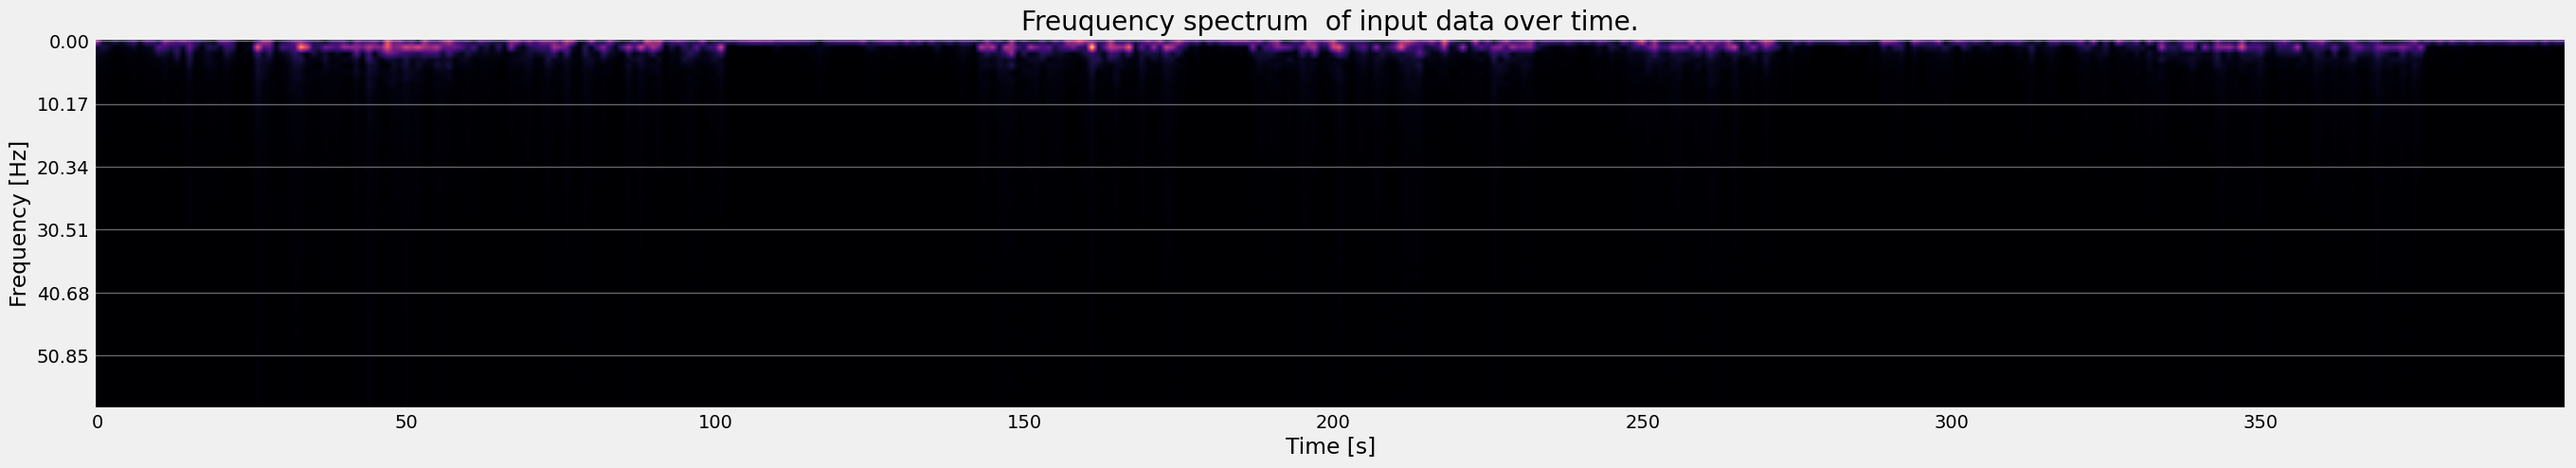

In [41]:
T = 1.0 / 120.0 # fs

# FFT of every window
X_fft = []
for num, x in enumerate(X_train):
    yf = scipy.fftpack.fft(x[:,0])
    X_fft.append(yf)
X_fft = np.array(X_fft)

n_samples = 400 # Only use certain amount of windows
a = 50000 # start index for plot
b = a + n_samples * win_len # End index
stride = win_len

sub_X = X_fft[a:b:stride]

X_fft_p = np.zeros((sub_X.shape[0], int(sub_X.shape[1]/2)))
for num, x in enumerate(sub_X):
    X_fft_p[num] = 2.0/win_len * np.abs(x[:N//2])

# Plot resulting FFT
fig = plt.figure()
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.facecolor'] = (1,1,1,0)
plt.imshow(np.transpose(X_fft_p), cmap='magma', interpolation='bilinear') #cmap ='hot'
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))
plt.yticks(xf[::10])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Freuquency spectrum  of input data over time.')
plt.grid(True, alpha=.5, axis = 'y')
plt.grid(True, axis='x', alpha = 0)
plt.show()


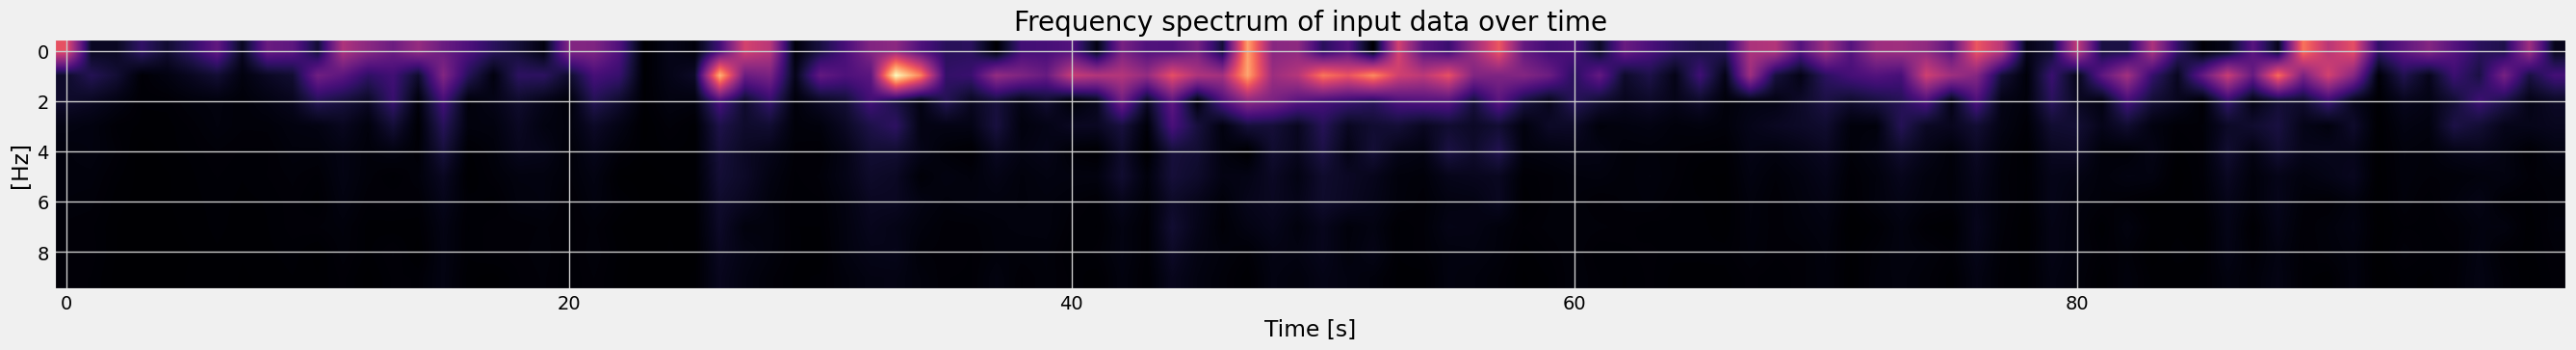

In [44]:
# Display smaller window for more detailed view
plt.imshow(np.transpose(X_fft_p[:100,:10]), cmap='magma', interpolation='bilinear') #cmap ='hot'
plt.ylabel('[Hz]')
plt.xlabel('Time [s]')
plt.title('Frequency spectrum of input data over time')
plt.show()

5 Hz already carry 98.26% of the average signal energy.
10 Hz already carry 99.16% of the average signal energy.


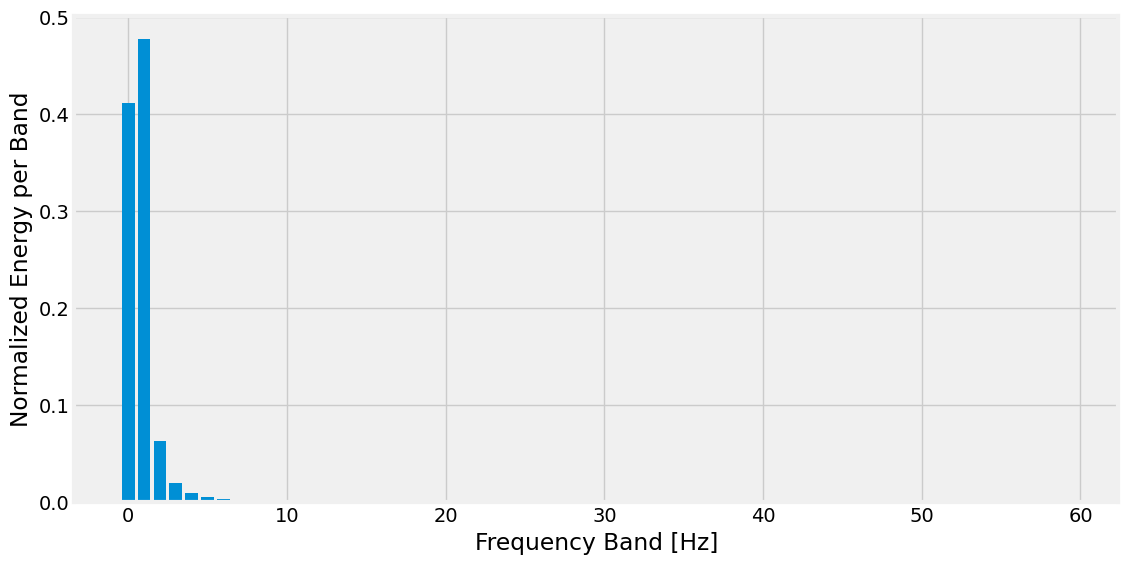

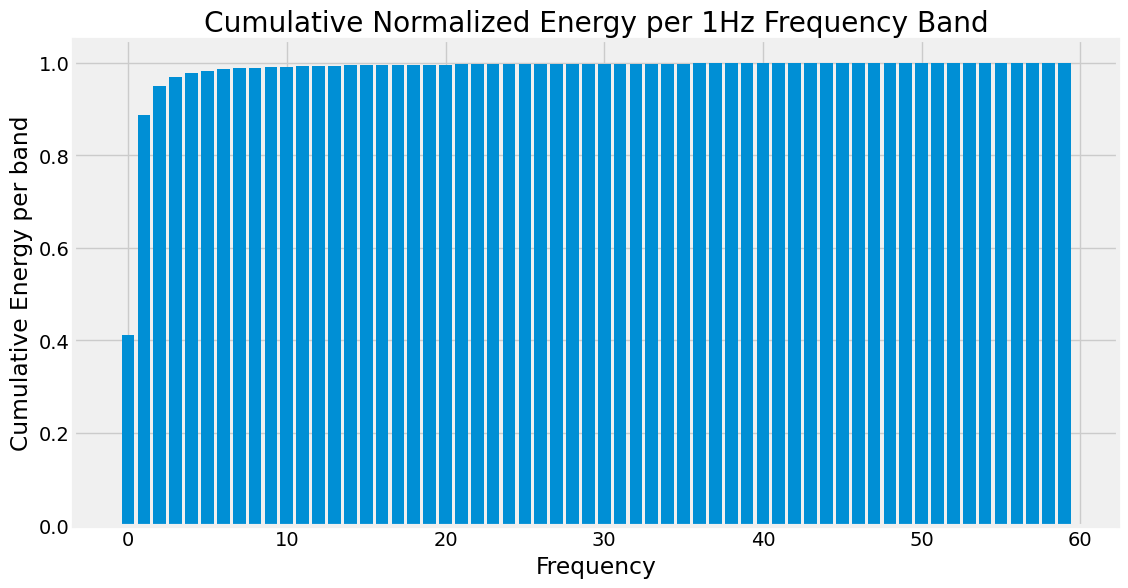

In [45]:
# Convert FFT to absolute values
X_s = np.zeros((X_fft.shape[0], int(X_fft.shape[1]/2)))
for num, x in enumerate(X_fft):
    X_s[num] = 2.0/N * np.abs(x[:N//2])
X_s.shape

# Calculate Energy
E_tot = np.sum(X_s * X_s)
Es = np.zeros((60))
for f in range(X_s.shape[1]):
    Es[f] = np.sum(X_s[:,f] * X_s[:,f])/E_tot

E_sum = np.cumsum(Es) # Create cummulative sum

# Plots
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['figure.facecolor'] = (1,1,1,0)
plt.bar(np.linspace(0,59,60),Es)
plt.xlabel('Frequency Band [Hz]')
plt.ylabel('Normalized Energy per Band')
plt.figure()
plt.title('Normalized Energy per 1Hz Frequency Band')

plt.bar(np.linspace(0,59,60), E_sum)
plt.xlabel('Frequency')
plt.ylabel('Cumulative Energy per band');
plt.title('Cumulative Normalized Energy per 1Hz Frequency Band')

print(f'{5} Hz already carry {100*E_sum[5]:.2f}% of the average signal energy.')
print(f'{10} Hz already carry {100*E_sum[10]:.2f}% of the average signal energy.')

## Cutoff Frequency experiments
We compare different filtering strategies using different cutoff frequencies and orders of filters.

In [46]:
# Load some data to experiment with
data_path = 'Dataset/Converted_120Hz/'
files = os.listdir(data_path)

with open(data_path + files[0], 'rb') as infile:
    sample_d = pickle.load(infile)

In [47]:
def filter_signal(signal, f_cutoff = 10, f_sample = 120, order = 5):
    """filters signal at specified cutoff frequency using a Butterworth filter of specified order
    :param signal: input signal
    :param f_cutoff: Cutoff frequency
    :param f_sample: original sample rate of signal
    :param order: order of the filter
    """
    w = f_cutoff / (f_sample / 2) # Normalize the frequency must be between 0 < W < 1. 1 = 100% of Nyquist Freq. 0 = 0% of Nyqist Freq
    b,a = signal.butter(order, w, 'low')
    return signal.filtfilt(b,a, sig)

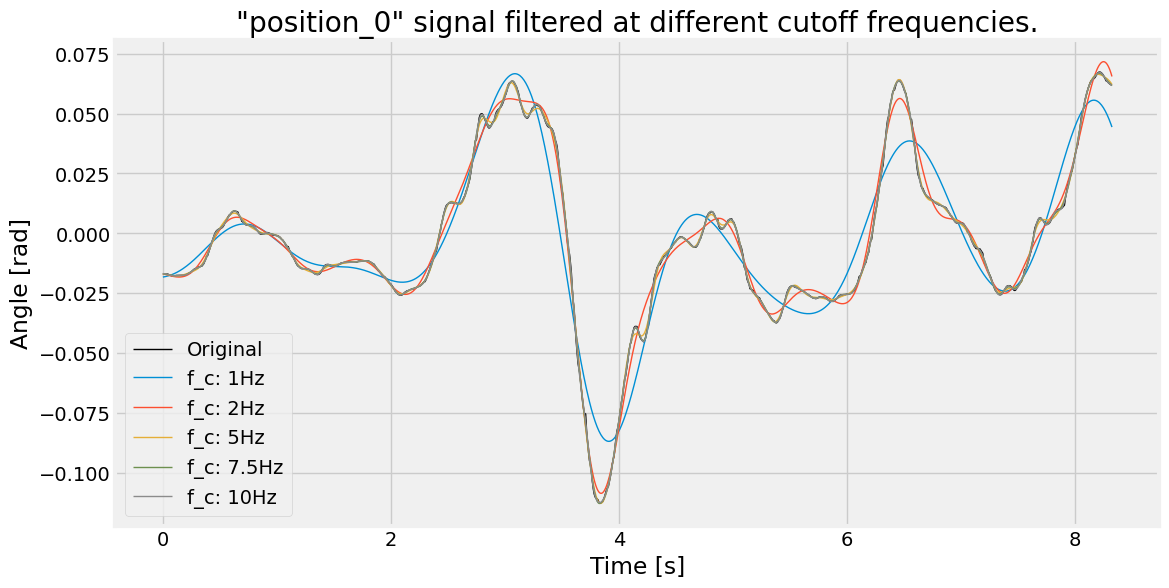

In [48]:
# create butterworth filter
from scipy import signal

sig = sample_d['position_0']

fs = sample_d['sample_rate']  # Sampling frequency
fc = 10  # Cut-off frequency of the filter

# Generate the time vector
t = np.arange(sig.shape[0])/fs

def butterworth_filter_signal(sig, f_cutoff = 10, f_sample = 120, order = 5):
    """filters signal at specified cutoff frequency using a Butterworth filter of specified order
    :param signal: input signal
    :param f_cutoff: Cutoff frequency
    :param f_sample: original sample rate of signal
    :param order: order of the filter
    """
    w = f_cutoff / (f_sample / 2) # Normalize the frequency must be between 0 < W < 1. 1 = 100% of Nyquist Freq. 0 = 0% of Nyqist Freq
    b,a = scipy.signal.butter(order, w, 'low')
    return signal.filtfilt(b,a, sig)


fcs = [1,2,5,7.5,10]
sigs_f = dict()
a = 0
e = 1000

plt.plot(t[a:e], sig[a:e], label='Original', color = 'black')

for i, f in enumerate(fcs):
    sigs_f[f] = butterworth_filter_signal(sig, f)
    plt.plot(t[a:e], sigs_f[f][a:e], label= f'f_c: {f}Hz')

plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('"position_0" signal filtered at different cutoff frequencies.')
plt.show()

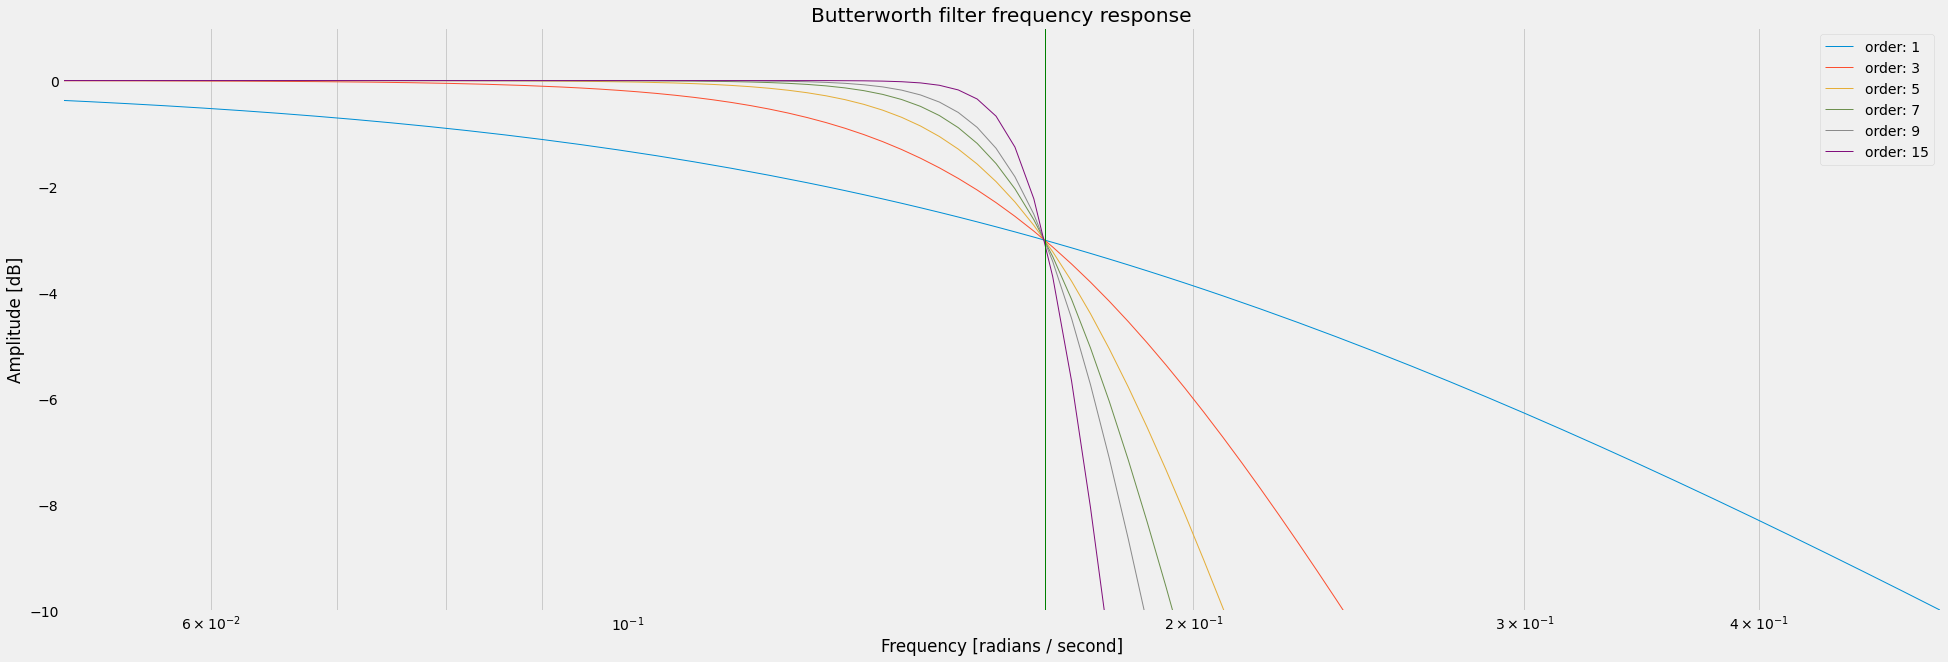

In [74]:
W = 10 / (120 / 2) # Normalize the frequency must be between 0 < W < 1. 1 = 100% of Nyquist Freq. 0 = 0% of Nyqist Freq
orders = [1, 3, 5, 7, 9, 15]

hs = []
for o in orders:
    b, a = signal.butter(o, W, 'low', analog=True)
    w,h = signal.freqs(b, a)
    plt.semilogx(w, 20 * np.log10(abs(h)), label=f'order: {o}')

plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.ylim([-10,1])
plt.xlim([0.05, 0.5])
plt.grid(which='both', axis='both')
plt.axvline(W, color='green') # cutoff frequency
plt.legend()

